# Download GRIBs

In [41]:
import os
import requests
import xarray as xr
import numpy as np
from datetime import datetime, timedelta

def download_grib(date, cycle, forecast_hour):

    # Generate timestamp based on date, cycle, and forecast hour
    # Convert date string to datetime object
    year = int(date[0:4])
    month = int(date[4:6])
    day = int(date[6:8])
    
    # Convert cycle string to integer hours
    cycle_hours = int(cycle)
    
    # Create datetime object with date and cycle time
    base_time = datetime.datetime(year, month, day, cycle_hours, 0)
    
    # Add forecast hours to get the actual forecast time
    forecast_time = base_time + datetime.timedelta(hours=forecast_hour)
    
    # Convert to unix timestamp (seconds since epoch)
    unix_timestamp = int(forecast_time.timestamp())
    
    # Format forecast hour as a three-digit string
    fcst = str(forecast_hour).zfill(3)
    
    # Construct filename; here we assume a control run file from the "pgrb2b" directory.
    # Example: gec00.t12z.pgrb2af006
    filename = f"geavg.t{cycle}z.pgrb2a.0p50.f{fcst}"
    
    # Set up local file path in gribs folder
    local_file = os.path.join("gribs", date, f'{unix_timestamp}.grib2')
    
    # Check if file already exists
    if os.path.exists(local_file):
        print(f"File {filename} already exists in gribs folder, skipping download")
    else:
        # Create gribs directory if it doesn't exist
        os.makedirs(os.path.join("gribs", date), exist_ok=True)
        
        # Construct URL using the NOAA GEFS public bucket structure
        url = f"https://noaa-gefs-pds.s3.amazonaws.com/gefs.{date}/{cycle}/atmos/pgrb2ap5/{filename}"
        # print(f"Downloading from: {url}")
        
        # Download the GRIB file
        response = requests.get(url)
        if response.status_code == 200:
            with open(local_file, "wb") as f:
                f.write(response.content)
            # print("Download successful.")
        else:
            raise Exception(f"Failed to download file. HTTP status code: {response.status_code}")


In [42]:
import datetime
import pandas as pd

# Generate dates from 2023-01-04 to 2023-12-01 (inclusive)
start_date = datetime.datetime(2023, 1, 4)
end_date = datetime.datetime(2023, 12, 1)
date_range = pd.date_range(start=start_date, end=end_date)

# Format dates as YYYYMMDD
formatted_dates = [date.strftime("%Y%m%d") for date in date_range]

# Define cycles and forecast hours
cycles = ["00", "06", "12", "18"]
forecast_hours = [0, 3]  # Will be formatted as "000" and "003"

# Print parameters for downloading GRIB files
print(f"Generated {len(formatted_dates)} dates from 2023-01-04 to 2023-12-01")
print(f"Cycles: {cycles}")
print(f"Forecast hours: {forecast_hours}")

# Create a list of all parameter combinations
download_params = []
for date in formatted_dates:
    for cycle in cycles:
        for fhour in forecast_hours:
            download_params.append({
                "date": date,
                "cycle": cycle,
                "forecast_hour": fhour
            })

print(f"Total number of files to potentially download: {len(download_params)}")

# Display first few parameter combinations as examples
print("\nExample parameter combinations:")
for params in download_params[:5]:
    print(f"Date: {params['date']}, Cycle: {params['cycle']}, Forecast hour: {params['forecast_hour']}")


Generated 332 dates from 2023-01-04 to 2023-12-01
Cycles: ['00', '06', '12', '18']
Forecast hours: [0, 3]
Total number of files to potentially download: 2656

Example parameter combinations:
Date: 20230104, Cycle: 00, Forecast hour: 0
Date: 20230104, Cycle: 00, Forecast hour: 3
Date: 20230104, Cycle: 06, Forecast hour: 0
Date: 20230104, Cycle: 06, Forecast hour: 3
Date: 20230104, Cycle: 12, Forecast hour: 0


In [ ]:
def download_grib_wrapper(date, cycle, forecast_hour):
    """Wrapper function for download_grib to use with MPIRE"""
    try:
        download_grib(date, cycle, forecast_hour)
        return f"Successfully downloaded: Date: {params['date']}, Cycle: {params['cycle']}, Forecast hour: {params['forecast_hour']}"
    except Exception as e:
        return f"Error downloading: Date: {params['date']}, Cycle: {params['cycle']}, Forecast hour: {params['forecast_hour']} - {str(e)}"

# Install MPIRE if not already installed
try:
    import mpire
except ImportError:
    print("Installing MPIRE...")
    !pip install mpire
    import mpire

from mpire import WorkerPool
import time

# Set the maximum number of processes
max_processes = 4

# Create a progress tracker
total_files = len(download_params)
print(f"Starting parallel download of {total_files} files using {max_processes} processes")

start_time = time.time()

# Use MPIRE for parallel processing
with WorkerPool(n_jobs=max_processes) as pool:
    results = pool.map(download_grib_wrapper, download_params, progress_bar=True)

# Print summary
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nDownload completed in {elapsed_time:.2f} seconds")

# Count successes and failures
successes = sum(1 for result in results if result.startswith("Successfully"))
failures = total_files - successes
print(f"Successfully downloaded: {successes} files")
print(f"Failed to download: {failures} files")

# Print first few failures if any
if failures > 0:
    print("\nSample of failures:")
    failure_samples = [result for result in results if not result.startswith("Successfully")][:5]
    for sample in failure_samples:
        print(sample)

In [47]:
import pygrib
def filter_for_europe(grib_path):
    # Open the GRIB file
    grbs = pygrib.open(grib_path)

    # Filter for CAPE message at 18000
    cape_msg = grbs.select(name='Convective available potential energy', typeOfLevel='pressureFromGroundLayer', level=18000)[0]
    # Filter for CIN message (Convective Inhibition)
    cin_msg = grbs.select(name='Convective inhibition', typeOfLevel='pressureFromGroundLayer', level=18000)[0]
    # Filter for wind components at 250 mb
    u_wind_msg = grbs.select(name='U component of wind', typeOfLevel='isobaricInhPa', level=250)[0]
    v_wind_msg = grbs.select(name='V component of wind', typeOfLevel='isobaricInhPa', level=250)[0]

    # Get the data and coordinates
    data_cape, lats, lons = cape_msg.data()
    data_cin, lats, lons = cin_msg.data()
    data_u_wind, lats, lons = u_wind_msg.data()
    data_v_wind, lats, lons = v_wind_msg.data()

    lat_indices = np.concatenate((np.arange(690, 720), np.arange(0, 81)), axis=0)
    lon_indices = np.arange(36, 121)
    lat_grid, lon_grid = np.meshgrid(lon_indices, lat_indices)

    # Create longitude and latitude arrays for Europe
    lon_europe = np.arange(-15, 40.5, 0.5)  # -15 to 40 with 0.25 step
    lat_europe = np.arange(30, 72.5, 0.5)   # 30 to 72 with 0.25 step

    # Extract data at these grid points
    europe_cape = data_cape[lat_grid, lon_grid] # Europe
    europe_cin = data_cin[lat_grid, lon_grid] # Europe
    europe_u_wind = data_u_wind[lat_grid, lon_grid] # Europe
    europe_v_wind = data_v_wind[lat_grid, lon_grid] # Europe

    # Create an xarray Dataset to store the European meteorological data
    import xarray as xr

    # Create coordinate arrays
    coords = {
        'latitude': (['latitude'], lat_europe),
        'longitude': (['longitude'], lon_europe)
    }

    # Create data variables dictionary with their corresponding data and attributes
    data_vars = {
        'cape': (['latitude', 'longitude'], europe_cape.T, {
            'long_name': 'Convective Available Potential Energy',
            'units': 'J/kg',
            'standard_name': 'atmosphere_convective_available_potential_energy'
        }),
        'cin': (['latitude', 'longitude'], europe_cin.T, {
            'long_name': 'Convective Inhibition',
            'units': 'J/kg',
            'standard_name': 'atmosphere_convective_inhibition'
        }),
        'u_wind': (['latitude', 'longitude'], europe_u_wind.T, {
            'long_name': 'U-component of wind',
            'units': 'm/s',
            'standard_name': 'eastward_wind'
        }),
        'v_wind': (['latitude', 'longitude'], europe_v_wind.T, {
            'long_name': 'V-component of wind',
            'units': 'm/s',
            'standard_name': 'northward_wind'
        })
    }

    # Create the xarray Dataset
    europe_ds = xr.Dataset(
        data_vars=data_vars,
        coords=coords,
        attrs={
            'description': 'European meteorological data extracted from GRIB file',
            'region': 'Europe',
            'source': 'GRIB file'
        }
    )

    # Calculate and add wind speed as a derived variable
    europe_ds['wind_speed'] = np.sqrt(europe_ds.u_wind**2 + europe_ds.v_wind**2)
    europe_ds.wind_speed.attrs = {
        'long_name': 'Wind Speed',
        'units': 'm/s',
        'standard_name': 'wind_speed'
    }

    # Save to netCDF file
    # Extract the base filename from gribpath and replace .grib2 extension with .nc
    output_file = os.path.basename(grib_path).replace('.grib2', '.nc')
    europe_ds.to_netcdf(os.path.join('cdfs', output_file))




In [48]:
def process_grib_files_to_netcdf():
    """
    Recursively search for all .grib2 files in the gribs folder,
    process them using filter_for_europe function in parallel,
    and save the results as NetCDF files.
    """
    import os
    import time
    import glob
    from mpire import WorkerPool
    
    # Create cdfs directory if it doesn't exist
    os.makedirs("cdfs", exist_ok=True)
    
    # Find all .grib2 files recursively in the gribs folder
    grib_files = glob.glob("gribs/**/*.grib2", recursive=True)
    
    # Define a wrapper function for parallel processing
    def process_grib_wrapper(grib_path):
        try:
            filter_for_europe(grib_path)
            return f"Successfully processed: {grib_path}"
        except Exception as e:
            return f"Error processing: {grib_path} - {str(e)}"
    
    # Set the maximum number of processes
    max_processes = 4
    
    # Create a progress tracker
    total_files = len(grib_files)
    print(f"Starting parallel processing of {total_files} GRIB files using {max_processes} processes")
    
    start_time = time.time()
    
    # Use MPIRE for parallel processing
    with WorkerPool(n_jobs=max_processes) as pool:
        results = pool.map(process_grib_wrapper, grib_files, progress_bar=True)
    
    # Print summary
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nProcessing completed in {elapsed_time:.2f} seconds")
    
    # Count successes and failures
    successes = sum(1 for result in results if result.startswith("Successfully"))
    failures = total_files - successes
    print(f"Successfully processed: {successes} files")
    print(f"Failed to process: {failures} files")
    
    # Print first few failures if any
    if failures > 0:
        print("\nSample of failures:")
        failure_samples = [result for result in results if not result.startswith("Successfully")][:5]
        for sample in failure_samples:
            print(sample)

Saving data to geavg.t00z.pgrb2a.0p50.f000


In [26]:
import pygrib

# Open the GRIB file
grbs = pygrib.open('gribs/geavg.t00z.pgrb2a.0p50.f000')
# List all messages in the GRIB file
print("Listing all messages in the GRIB file:")
print("-" * 50)

# Initialize counter
count = 1

# Loop through all messages in the GRIB file
for grb in grbs:
    # Extract key information from each message
    message_info = f"{count}: {grb.shortName} - {grb.name} - {grb.level} {grb.typeOfLevel}"
    
    # Add forecast time if available
    if hasattr(grb, 'forecastTime'):
        message_info += f" - forecast hour: {grb.forecastTime}"
    
    # Add statistical processing type if available (like ensemble mean)
    if hasattr(grb, 'typeOfProcessedData'):
        process_type = grb.typeOfProcessedData
        if process_type == 4:
            message_info += " - ensemble mean"
    
    print(message_info)
    count += 1

# Reset the iterator for future use
grbs.rewind()


Listing all messages in the GRIB file:
--------------------------------------------------
1: gh - Geopotential height - 10 isobaricInhPa - forecast hour: 0
2: t - Temperature - 10 isobaricInhPa - forecast hour: 0
3: r - Relative humidity - 10 isobaricInhPa - forecast hour: 0
4: u - U component of wind - 10 isobaricInhPa - forecast hour: 0
5: v - V component of wind - 10 isobaricInhPa - forecast hour: 0
6: gh - Geopotential height - 50 isobaricInhPa - forecast hour: 0
7: t - Temperature - 50 isobaricInhPa - forecast hour: 0
8: r - Relative humidity - 50 isobaricInhPa - forecast hour: 0
9: u - U component of wind - 50 isobaricInhPa - forecast hour: 0
10: v - V component of wind - 50 isobaricInhPa - forecast hour: 0
11: gh - Geopotential height - 100 isobaricInhPa - forecast hour: 0
12: t - Temperature - 100 isobaricInhPa - forecast hour: 0
13: r - Relative humidity - 100 isobaricInhPa - forecast hour: 0
14: u - U component of wind - 100 isobaricInhPa - forecast hour: 0
15: v - V componen

In [27]:
# Filter for CAPE message at 18000
cape_msg = grbs.select(name='Convective available potential energy', typeOfLevel='pressureFromGroundLayer', level=18000)[0]
# Filter for CIN message (Convective Inhibition)
cin_msg = grbs.select(name='Convective inhibition', typeOfLevel='pressureFromGroundLayer', level=18000)[0]

# Filter for wind components at 250 mb
u_wind_msg = grbs.select(name='U component of wind', typeOfLevel='isobaricInhPa', level=250)[0]
v_wind_msg = grbs.select(name='V component of wind', typeOfLevel='isobaricInhPa', level=250)[0]

# Print information about the selected messages
print(f"Selected CAPE message: {cape_msg}")
print(f"Selected CIN message: {cin_msg}")
print(f"Selected U wind message: {u_wind_msg}")
print(f"Selected V wind message: {v_wind_msg}")


Selected CAPE message: 69:Convective available potential energy:J kg**-1 (instant):regular_ll:pressureFromGroundLayer:levels 18000-0 Pa:fcst time 0 hrs:from 202304010000:ens mean
Selected CIN message: 70:Convective inhibition:J kg**-1 (instant):regular_ll:pressureFromGroundLayer:levels 18000-0 Pa:fcst time 0 hrs:from 202304010000:ens mean
Selected U wind message: 24:U component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level 25000 Pa:fcst time 0 hrs:from 202304010000:ens mean
Selected V wind message: 25:V component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level 25000 Pa:fcst time 0 hrs:from 202304010000:ens mean


Determining for Europe

In [28]:
# Get the data and coordinates
data_cape, lats, lons = cape_msg.data()
data_cin, lats, lons = cin_msg.data()
data_u_wind, lats, lons = u_wind_msg.data()
data_v_wind, lats, lons = v_wind_msg.data()

# Create a mask for the European region
lat_mask = (lats >= 30) & (lats <= 72)
lon_mask = (lons >= 345) | (lons <= 40)
mask = lat_mask & lon_mask

Text(0.5, 1.0, 'Where in the GRIB grid do we need to take values (for Europe)')

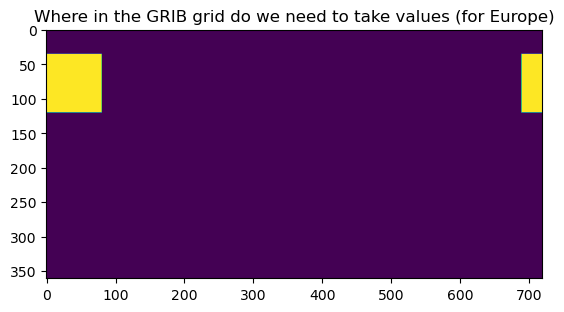

In [29]:
from matplotlib import pyplot as plt
plt.imshow(mask)
plt.title('Where in the GRIB grid do we need to take values (for Europe)')

We need to convert that mask into a grid for Europe. First step is to find the indices from the data matrix we need to take values from.

In [30]:
import numpy as np
print('For longitude, notice the beginning indices and the end indices')
print(np.where(mask)[1][:1000])
print('We can see 0->80 (inc.) and 690->719 (inc.)')


For longitude, notice the beginning indices and the end indices
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80 690 691 692 693 694 695 696 697 698
 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716
 717 718 719   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14
  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32
  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80 690 691 692 693 694 695
 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713
 714 715 716 717 718 719   0   1   2   3   4   5   6   7   8

In [31]:
print('For latitude, notice the beginning indices and the end indices')
print(np.where(mask)[0][:-1])
print('We can see 36->120')


For latitude, notice the beginning indices and the end indices
[ 36  36  36 ... 120 120 120]
We can see 36->120


In [32]:
lat_indices = np.concatenate((np.arange(690, 720), np.arange(0, 81)), axis=0)
lon_indices = np.arange(36, 121)
print(f'Size of latitude grid: {len(lat_indices)}')
print(f'Size of longitude grid: {len(lon_indices)}')
# Create meshgrid from lat_indices and lon_indices
lat_grid, lon_grid = np.meshgrid(lon_indices, lat_indices)

# Extract data at these grid points
europe_cape = data_cape[lat_grid, lon_grid] # Europe
europe_cin = data_cin[lat_grid, lon_grid] # Europe
europe_u_wind = data_u_wind[lat_grid, lon_grid] # Europe
europe_v_wind = data_v_wind[lat_grid, lon_grid] # Europe


Size of latitude grid: 111
Size of longitude grid: 85


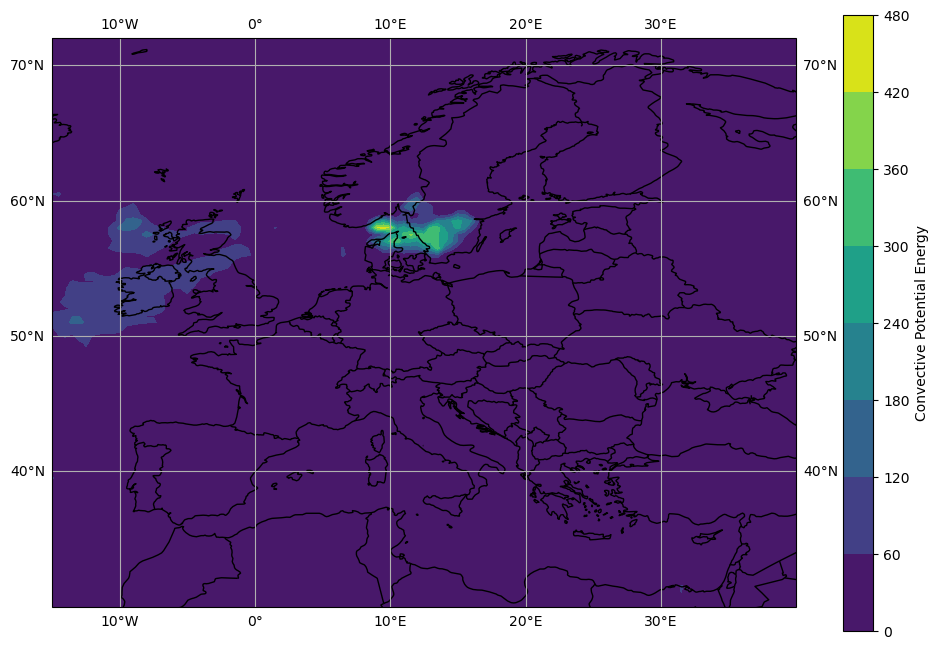

In [38]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create longitude and latitude arrays for Europe
lon_europe = np.arange(-15, 40.5, 0.5)  # -15 to 40 with 0.25 step
lat_europe = np.arange(30, 72.5, 0.5)   # 30 to 72 with 0.25 step

# Create figure and axis with projection
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

# Create meshgrid for plotting
lon_mesh, lat_mesh = np.meshgrid(lon_europe, lat_europe)

# Plot the data
plt.contourf(lon_mesh, lat_mesh, europe_cape.T, transform=ccrs.PlateCarree(), cmap='viridis')

# Add colorbar
plt.colorbar(label='Convective Potential Energy')

# Set title and labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set map extent
ax.set_extent([-15, 40, 30, 72], crs=ccrs.PlateCarree())

# Add gridlines
ax.gridlines(draw_labels=True)

plt.show()


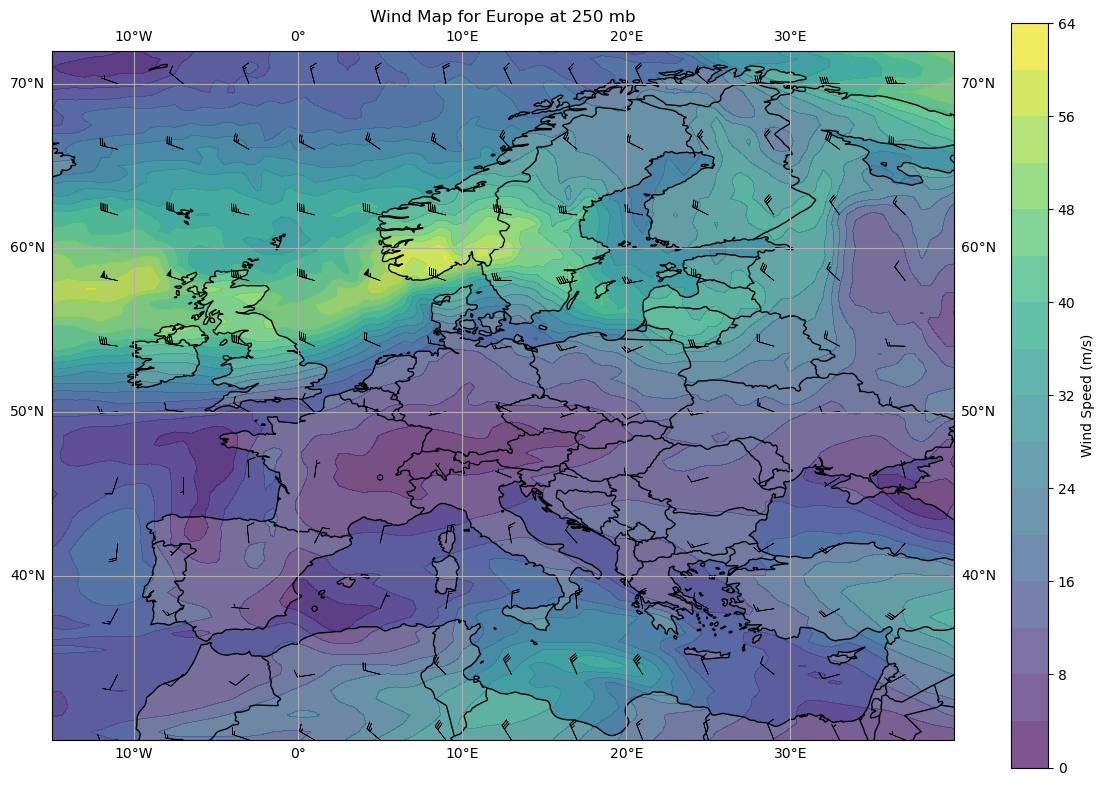

In [40]:
# Create a new figure for wind map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

# Create meshgrid for plotting
lon_mesh, lat_mesh = np.meshgrid(lon_europe, lat_europe)

# Calculate wind speed
wind_speed = np.sqrt(europe_u_wind**2 + europe_v_wind**2)

# Plot wind speed as a filled contour
contour = plt.contourf(lon_mesh, lat_mesh, wind_speed.T, transform=ccrs.PlateCarree(), 
                       cmap='viridis', levels=15, alpha=0.7)

# Add wind barbs (subsample for clarity)
stride = 8  # Adjust this value to change the density of wind barbs
plt.barbs(lon_mesh[::stride, ::stride], lat_mesh[::stride, ::stride],
          europe_u_wind[::stride, ::stride].T, europe_v_wind[::stride, ::stride].T,
          transform=ccrs.PlateCarree(), length=5, linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(contour, label='Wind Speed (m/s)')

# Set title and labels
ax.set_title('Wind Map for Europe at 250 mb')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set map extent
ax.set_extent([-15, 40, 30, 72], crs=ccrs.PlateCarree())

# Add gridlines
ax.gridlines(draw_labels=True)

plt.tight_layout()
plt.show()


In [44]:
# Create an xarray Dataset to store the European meteorological data
import xarray as xr

# Create coordinate arrays
coords = {
    'latitude': (['latitude'], lat_europe),
    'longitude': (['longitude'], lon_europe)
}

# Create data variables dictionary with their corresponding data and attributes
data_vars = {
    'cape': (['latitude', 'longitude'], europe_cape.T, {
        'long_name': 'Convective Available Potential Energy',
        'units': 'J/kg',
        'standard_name': 'atmosphere_convective_available_potential_energy'
    }),
    'cin': (['latitude', 'longitude'], europe_cin.T, {
        'long_name': 'Convective Inhibition',
        'units': 'J/kg',
        'standard_name': 'atmosphere_convective_inhibition'
    }),
    'u_wind': (['latitude', 'longitude'], europe_u_wind.T, {
        'long_name': 'U-component of wind',
        'units': 'm/s',
        'standard_name': 'eastward_wind'
    }),
    'v_wind': (['latitude', 'longitude'], europe_v_wind.T, {
        'long_name': 'V-component of wind',
        'units': 'm/s',
        'standard_name': 'northward_wind'
    })
}

# Create the xarray Dataset
europe_ds = xr.Dataset(
    data_vars=data_vars,
    coords=coords,
    attrs={
        'description': 'European meteorological data extracted from GRIB file',
        'region': 'Europe',
        'source': 'GRIB file'
    }
)

# Calculate and add wind speed as a derived variable
europe_ds['wind_speed'] = np.sqrt(europe_ds.u_wind**2 + europe_ds.v_wind**2)
europe_ds.wind_speed.attrs = {
    'long_name': 'Wind Speed',
    'units': 'm/s',
    'standard_name': 'wind_speed'
}

# Display dataset information
print(europe_ds)


<xarray.Dataset> Size: 379kB
Dimensions:     (latitude: 85, longitude: 111)
Coordinates:
  * latitude    (latitude) float64 680B 30.0 30.5 31.0 31.5 ... 71.0 71.5 72.0
  * longitude   (longitude) float64 888B -15.0 -14.5 -14.0 ... 39.0 39.5 40.0
Data variables:
    cape        (latitude, longitude) float64 75kB 1.0 1.0 1.0 ... 0.0 0.0 0.0
    cin         (latitude, longitude) float64 75kB -0.1 -0.1 0.0 ... 0.0 0.0 0.0
    u_wind      (latitude, longitude) float64 75kB 8.4 9.0 9.5 ... 50.2 50.9
    v_wind      (latitude, longitude) float64 75kB 2.9 2.1 1.6 ... 4.3 4.6 4.6
    wind_speed  (latitude, longitude) float64 75kB 8.887 9.242 ... 50.41 51.11
Attributes:
    description:  European meteorological data extracted from GRIB file
    region:       Europe
    source:       GRIB file


In [45]:
# Save the xarray dataset to a NetCDF file
# NetCDF is the most convenient format for xarray datasets as it preserves all metadata
output_file = 'europe_meteorological_data.nc'
europe_ds.to_netcdf(output_file)
print(f"Dataset saved to {output_file}")


Dataset saved to europe_meteorological_data.nc


In [46]:
!du -sh *

'du' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
